# Car Parking checker


Enric Ferrera González  
Miguel López Manzanares  
Joan Marc  

El objectiu del projecte de visió per computador es crear un programa que comprovi les plaçes d'aparcament d'un parking. Si están buides o plenes y en cas de que estiguin plenes, detectar la matrícula del coche, el color y si es pot la marca.  

Es realitzará de dues maneres, primer amb métodes clásics de la visió per computador y després amb métodes moderns com, per exemple, les xarxes neuronals. 

# Part clàsica

### 1. Dectectar línies
Per començar la part clàsica volem detectar les línies de les plaçes d'aparcament.

Per detectar les línies d'aparcament en una imatge d'un aparcament utilitzant mètodes clàssics de visió per computador, es poden seguir els següents passos:

1. **Conversió a escala de grisos:** Facilita el processament de la imatge.
2. **Filtrat de soroll:** S'utilitza un filtre com el Gaussian Blur per reduir el soroll.
3. **Detecció de vores:** S'aplica l'algoritme de Canny per detectar les vores de la imatge.
4. **Transformada de Hough:** Permet detectar línies rectes a la imatge, que corresponen a les línies d'aparcament.
5. **Dibuix de les línies detectades:** Es mostren les línies sobre la imatge original per visualitzar el resultat.

Aquests passos es poden implementar amb la llibreria OpenCV.

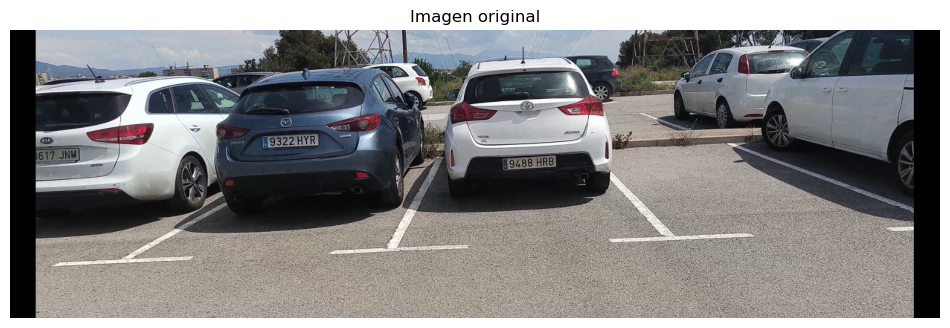

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title="", cmap='gray'):
    plt.figure(figsize=(12, 4))
    if len(img.shape) == 2:  # grayscale
        plt.imshow(img, cmap=cmap)
    else:  # BGR to RGB for color images
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Cargar imagen
image = cv2.imread("frames/img.jpg")
original = image.copy()
show_image(image, "Imagen original")

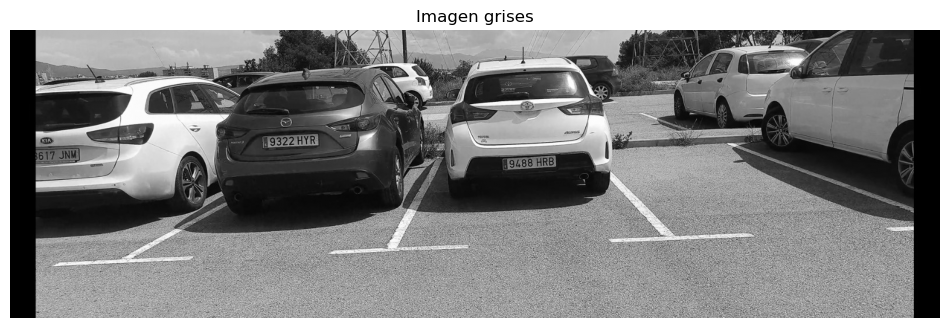

In [79]:
# Convertir a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_image(gray, "Imagen grises")

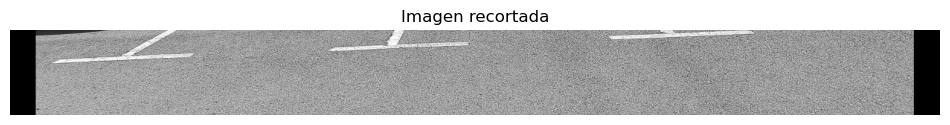

In [80]:
# Recortar si es necesario (ajustar offset si ya recortabas antes)
offset_y = 350
roi = gray[offset_y:]
roi_color = image[offset_y:]
show_image(roi, "Imagen recortada")

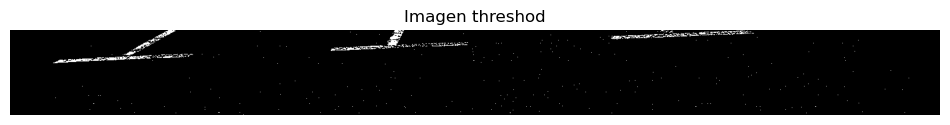

In [81]:
# Aplicar un threshold simple
_, thresh = cv2.threshold(roi, 230, 255, cv2.THRESH_BINARY)
show_image(thresh, "Imagen threshod")

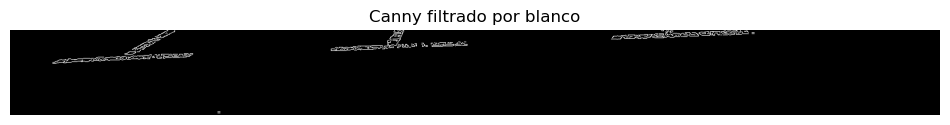

In [82]:
# --- Paso 3: Suavizado y Canny ---
blur = cv2.GaussianBlur(thresh, (3, 3), 0)
edges = cv2.Canny(blur, 350, 450)
show_image(edges, "Canny filtrado por blanco")

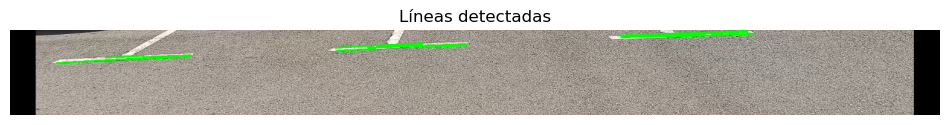

In [83]:
# --- Paso 4: Detección de líneas con Hough ---
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)
line_img = roi_color.copy()

'''
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
'''
        
# Dibuixar només les línies amb angle gairebé horitzontal o vertical
line_img = roi_color.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
        if abs(angle) < 10 or abs(angle - 90) < 10 or abs(angle + 90) < 10:
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

show_image(line_img, "Líneas detectadas")


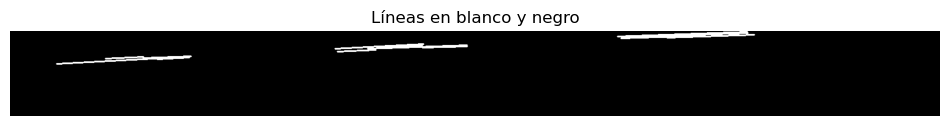

In [84]:
# Las ponemos en una imagen negra para poder contar bordes
# Crear imagen negra con las mismas dimensiones
line_mask = np.zeros_like(edges)

# Dibujar las líneas en blanco (valor 255)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
        if abs(angle) < 10 or abs(angle - 90) < 10 or abs(angle + 90) < 10:
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)

show_image(line_mask, "Líneas en blanco y negro")

In [85]:
# Asegurarse de que es binaria
_, binaria = cv2.threshold(line_mask, 127, 255, cv2.THRESH_BINARY)

# Opcional: cerrar huecos pequeños dentro de las regiones
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 5))  # más ancho que alto
cerrada = cv2.morphologyEx(binaria, cv2.MORPH_CLOSE, kernel)

# Encontrar contornos (cada uno será una región horizontal)
contornos, _ = cv2.findContours(cerrada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos por forma: horizontales (ancho >> alto)
regiones_horizontales = []
for c in contornos:
    x, y, w, h = cv2.boundingRect(c)
    if w > 2*h:  # puedes ajustar esta condición
        regiones_horizontales.append((x, y, w, h))

print(f"Regiones horizontales detectadas: {len(regiones_horizontales)}")
print(f"Plazas de parking detectadas: {len(regiones_horizontales)-1}")


Regiones horizontales detectadas: 3
Plazas de parking detectadas: 2


### Part2  
Ara detectarem les regions entre les línies per veure si hi ha un coche aparcat

In [86]:
regiones_ordenadas = sorted(regiones_horizontales, key=lambda r: r[0])


espacios_entre_regiones = []

for i in range(len(regiones_ordenadas) - 1):
    x1, _, w1, _ = regiones_ordenadas[i]
    x2, _, _, _ = regiones_ordenadas[i + 1]
    
    extremo_derecho = x1 + w1
    inicio_siguiente = x2

    if inicio_siguiente > extremo_derecho:
        espacio = (extremo_derecho, inicio_siguiente)  # coordenadas X del espacio entre regiones
        espacios_entre_regiones.append(espacio)


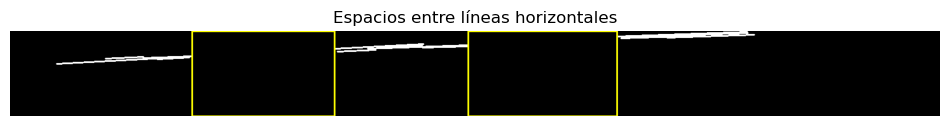

In [87]:
imagen_resultado = cv2.cvtColor(binaria, cv2.COLOR_GRAY2BGR)
alto_img = imagen_resultado.shape[0]

for x1, x2 in espacios_entre_regiones:
    cv2.rectangle(imagen_resultado, (x1, 0), (x2, alto_img), (0, 255, 255), 2)

show_image(imagen_resultado, "Espacios entre líneas horizontales")


Ahora con estás coordenadas, detectaremos si hay un coche en la parte de arriba de esa región

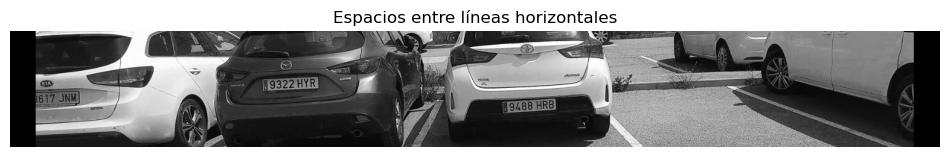

In [88]:
recorte = gray[100:300, :]
show_image(recorte, "Espacios entre líneas horizontales")


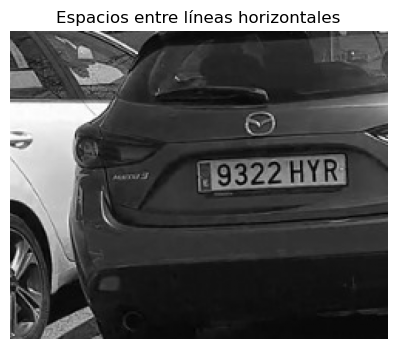

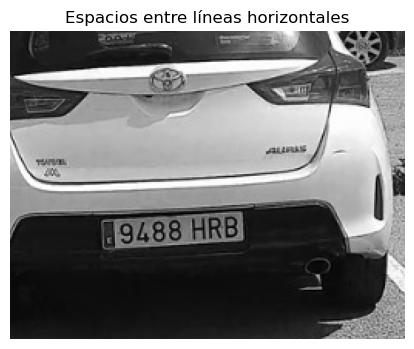

In [89]:
for i, (x_inicio, x_fin) in enumerate(espacios_entre_regiones, start=1):
    recorte_coche = recorte[:, x_inicio:x_fin]
    show_image(recorte_coche, "Espacios entre líneas horizontales")

In [90]:
import os

def load_templates(template_dir="plantilles", size=(40, 60)):
    templates = {}
    for filename in os.listdir(template_dir):
        label = filename.split(".")[0]
        path = os.path.join(template_dir, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size)
        _, bin_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
        templates[label] = bin_img
    return templates

def recognize_character(char_img, templates):
    char_resized = cv2.resize(char_img, (40, 60))
    _, char_bin = cv2.threshold(char_resized, 128, 255, cv2.THRESH_BINARY)

    best_score = float('-inf')
    best_match = '?'
    
    #print(f"Nou caracter a reconèixer")

    for label, tmpl in templates.items():
        result = cv2.matchTemplate(char_bin, tmpl, cv2.TM_CCOEFF_NORMED)
        score = result[0][0]
        if score > best_score:
            best_score = score
            best_match = label
        #print(f"Caracter: '{label}' | Score: {score:.4f}")
    return best_match


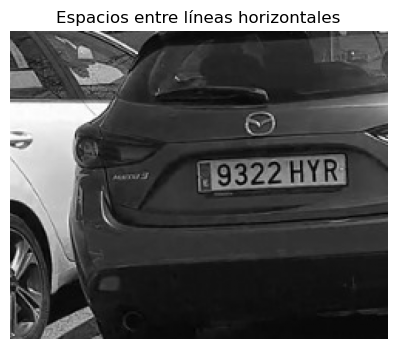

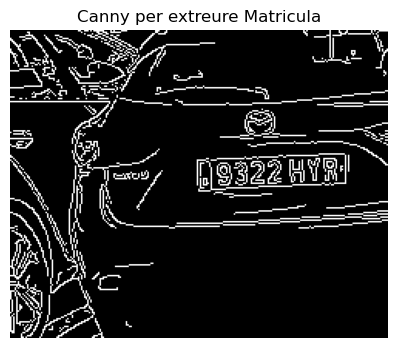

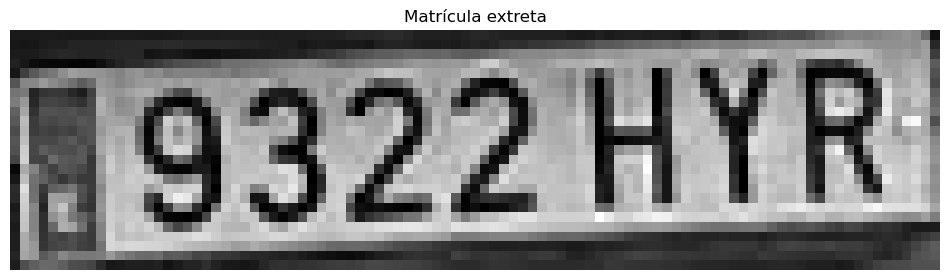

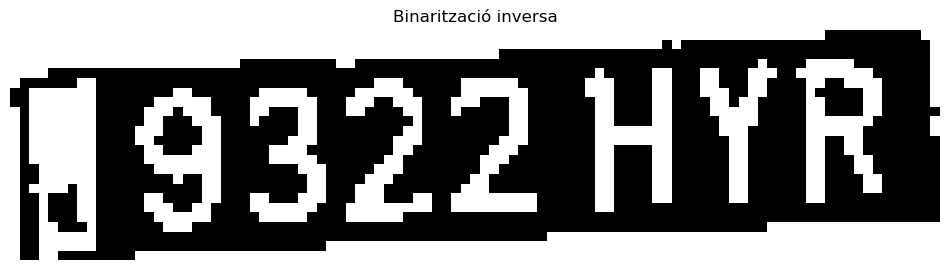

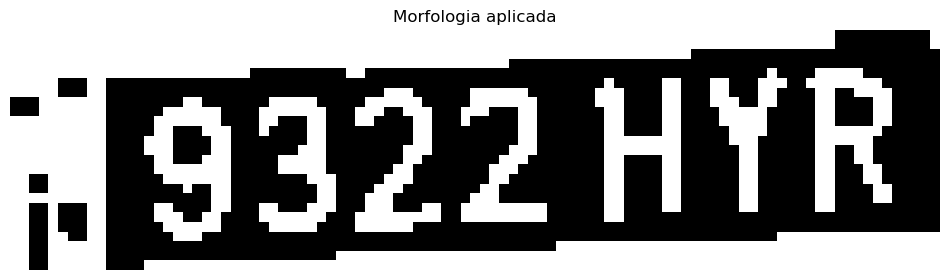

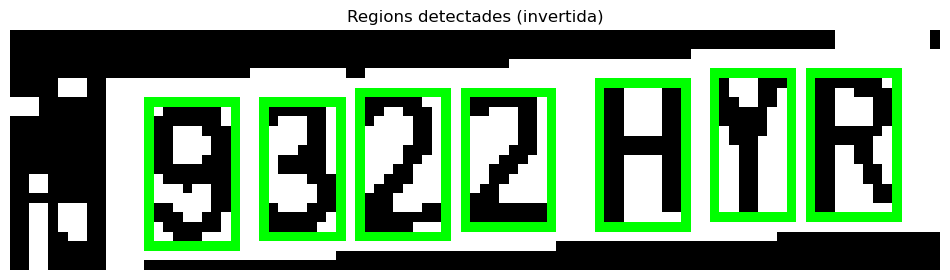

Caràcters detectats: 7


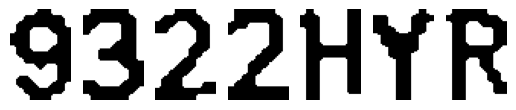

Matrícula detectada: 6322HYF


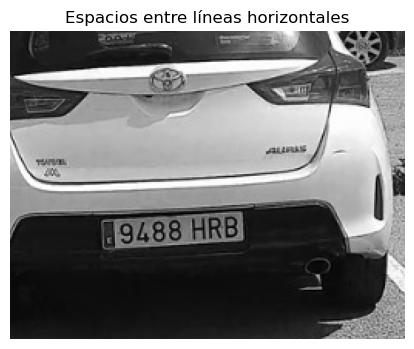

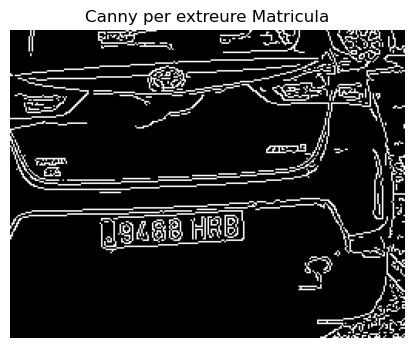

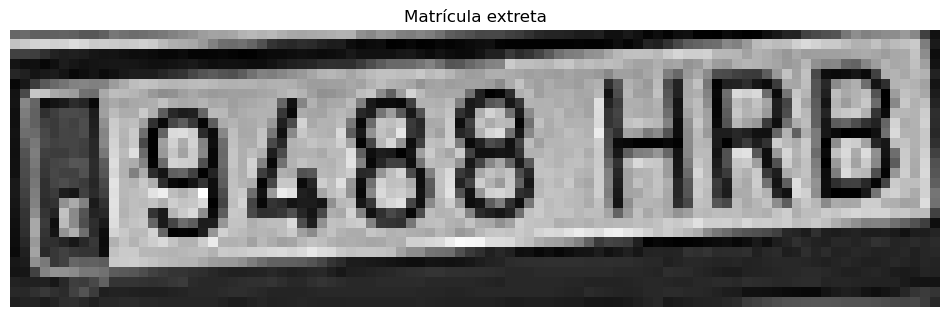

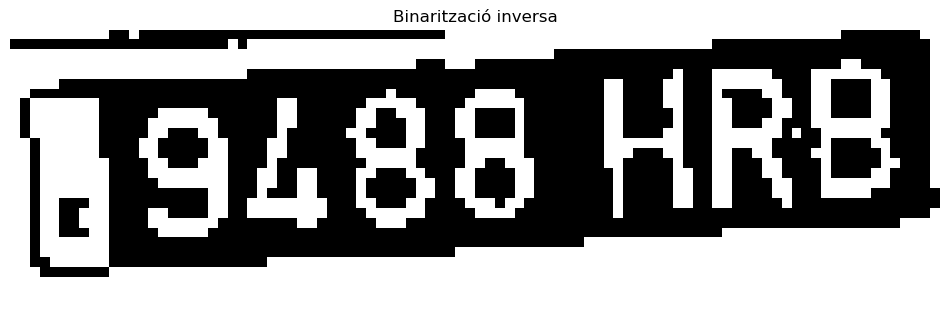

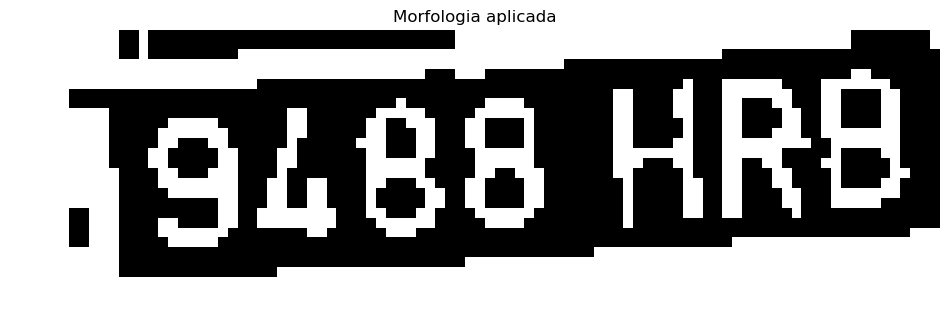

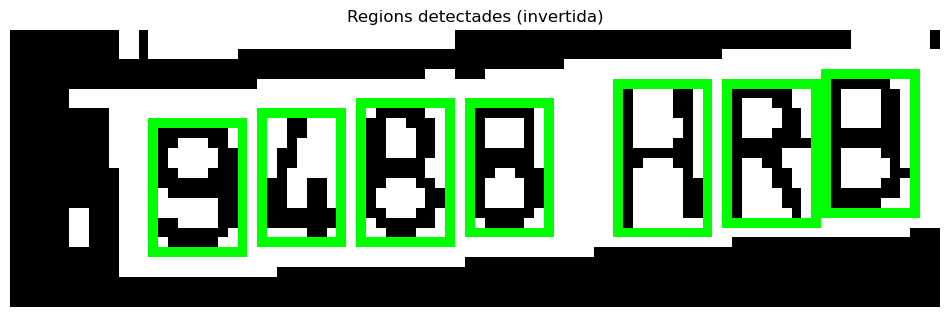

Caràcters detectats: 7


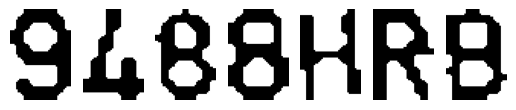

Matrícula detectada: 6466HRB


In [91]:
templates_numeros = load_templates("plantilles/numeros")
templates_lletres = load_templates("plantilles/lletres")

for i, (x_inicio, x_fin) in enumerate(espacios_entre_regiones, start=1):
    recorte_coche = recorte[:, x_inicio:x_fin]
    show_image(recorte_coche, "Espacios entre líneas horizontales")

    edges = cv2.Canny(recorte_coche, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    show_image(edges, "Canny per extreure Matricula")

    plate_crop = None
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspect_ratio = w / h if h != 0 else 0
        if 2000 < area < 15000 and 2.8 < aspect_ratio < 6.0:
            plate_crop = recorte_coche[y:y+h, x:x+w]
            show_image(plate_crop, "Matrícula extreta")
            break

    if plate_crop is None:
        print("No s'ha detectat cap matrícula.")
        continue

    if len(plate_crop.shape) == 3:
        gray_plate = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)
    else:
        gray_plate = plate_crop.copy()

    _, binary = cv2.threshold(gray_plate, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    show_image(binary, "Binarització inversa")

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    show_image(morph, "Morfologia aplicada")

    contours_letters, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    letter_regions = []
    for cnt in contours_letters:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = h / w if w != 0 else 0
        if 0.5 < aspect_ratio < 7.0 and 5 < w < 120:
            letter_regions.append((x, y, w, h))
    morph_inv = cv2.bitwise_not(morph)
    debug_img = cv2.cvtColor(morph_inv.copy(), cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in letter_regions:
        cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 1)
    show_image(debug_img, "Regions detectades (invertida)")

    print(f"Caràcters detectats: {len(letter_regions)}")

    if not letter_regions:
        print("⚠️ No s'han trobat lletres.")

    letter_regions = sorted(letter_regions, key=lambda r: r[0])
    matricula = ""

    for j, (x, y, w, h) in enumerate(letter_regions):
        pad = 2
        x1 = max(x - pad, 0)
        y1 = max(y - pad, 0)
        x2 = min(x + w + pad, morph_inv.shape[1])
        y2 = min(y + h + pad, morph_inv.shape[0])
        #char_img = morph_inv[y1:y2, x1:x2]

        # Pasa la iamtge a caracter
        char_img = morph_inv[y:y+h, x:x+w]

        # Millora del preprocessat
        char_img = cv2.resize(char_img, (40, 60))
        _, char_img = cv2.threshold(char_img, 128, 255, cv2.THRESH_BINARY)

        if(j+1 <= 4):
            lletra = recognize_character(char_img, templates_numeros)
        else:
            lletra = recognize_character(char_img, templates_lletres)
        matricula += lletra

        # Crea el mosaic de la matrícula detectada
        plt.subplot(1, len(letter_regions), j+1)
        plt.imshow(char_img, cmap='gray')
        plt.axis('off')
    plt.show()
    print("Matrícula detectada:", matricula)


In [96]:
# Només si tens OpenCV-contrib instal·lat
import cv2
ocr = cv2.text.OCRTesseract_create()
output_text = ocr.run(
    image=morph,                # Imatge d'entrada
    min_confidence=0,          # Llindar mínim de confiança
    component_level=cv2.text.OCR_LEVEL_WORD  # o OCR_LEVEL_TEXTLINE
)
print("Text detectat:", output_text)




Text detectat: 
